# __Stack Overflow public survey 2017__
***
***
## __Section 1. Business Understanding__

Through the Stackoverflow public survey 2017 dataset, I am trying to extract information about what is considered the best way to break into the field of software developper. We will particularly be interested in the data related to Data Scientists.
We will try to tackle the following questions:

1. How do respondents recommend to break into the field?
2. How do respondents did break into the field?  
    2.1 Is it the same for the sub-sample of Data Scientist?
3. Is there an impact of Training and Education on job satisfaction and salary?

Since I would like to get insights about successful professional positions, I will also be trying to model the salary of the respondents with the questions available in this survey. I would like to extract the variables that are the most important in the prediction of the salary.

---
___
## __Section 2. Data Understanding__
This public survey is of special interest to me because of one particular question coded ```CousinEducation``` which read as:
> _Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?_

This question is not found is the most recent Stack Overflow public surveys.

I will focus my attention on 3 different groups of respondents:

- For questions 1., 2., and 3. I will focus on a sub-sample of _recent-hires_ to focus on respondents that have a recent experience of getting a new job.

- For question 2.1, I will limit the analysis to a sub-sample of Data Scientists.

- Finally, for the model predicting the salary I will be focusing on a larger group of respondents identified has "Professionals" to increase the numbers of observations.

In [ ]:
# loading modules
import pandas as pd
import numpy as np
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick

from stack_functions import getChoices, convert2USD, createDummyVar

In [3]:
# setting up display
plt.style.use('fivethirtyeight')
# plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize']= 8, 8
plt.rcParams['font.size']=8

### Load the dataset

In [4]:
# load data and data schema
df = pd.read_csv('../DataSets/StackOverflow/survey-results-public.csv')
df_sch = pd.read_csv('../DataSets/StackOverflow/survey-results-schema.csv')

### What kind of professional are represented in this dataset?

In [5]:
# Using scheme file to gather information about the dataset
df_sch.query('Column == "Professional"')

,Column,Question
1,Professional,Which of the following best describes you?


In [6]:
md(f'>_There are "{df["Professional"].isna().sum()}" missing values in this category_')

>_There are "0" missing values in this category_

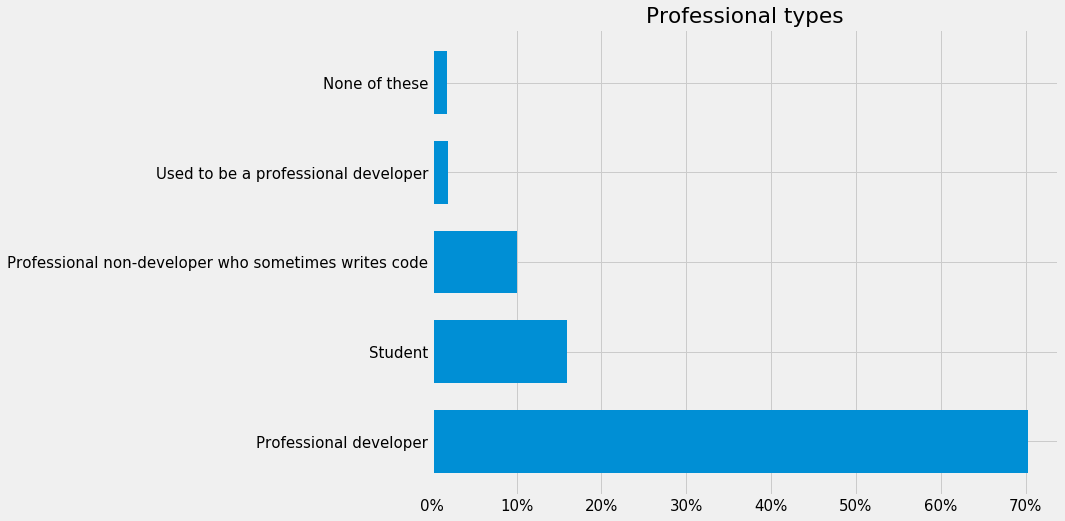

In [7]:
# shows count for each professional category
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=10,8

perc_pro = df['Professional'].value_counts(normalize=True)
ax = perc_pro.plot(kind='barh', title='Professional types', width=.7)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

---
---
## __Section 3. Preparing data__

> for the rest of this analysis we will focus on the __"Profesional developer"__ only

In [8]:
# We are keeping only "Professional developer"
df_pro = df.query('Professional == "Professional developer"')

- We will be preparing our group of respondents from the larger sub-sample to the smallest.
- For the final modeling and other salary related questions we will need to explore the salary of the respondents.

___
### Salary

Since Salary is the outcome that we are trying to model we chose to be really conservative in the quality of this variable by filtering out all observations with missing values. We also chose to drop missing values for _Currency_ since it was essential to convert the Salary to a common currency (no imputation would be reasonable anyway)

In [9]:
# filter dataset by removing all missing value in salary and missing Currency
df_pro = df_pro.dropna(subset=['Salary', 'Currency']).reset_index(drop=True)

__1. First explore the different currency reported in the dataset__

In [10]:
df_pro['Currency'].value_counts(normalize=True)

U.S. dollars ($)               0.357572
Euros (€)                      0.265344
British pounds sterling (£)    0.115327
Indian rupees (?)              0.066294
Canadian dollars (C$)          0.055203
Polish zloty (zl)              0.025934
Australian dollars (A$)        0.022515
Brazilian reais (R$)           0.019680
Swedish kroner (SEK)           0.016177
Russian rubles (?)             0.015594
Swiss francs                   0.013009
South African rands (R)        0.008839
Mexican pesos (MXN$)           0.007422
Japanese yen (¥)               0.004336
Chinese yuan renminbi (¥)      0.003919
Singapore dollars (S$)         0.002252
Bitcoin (btc)                  0.000584
Name: Currency, dtype: float64

__2. Convert Salary to USD equivalent salary__
> _CAUTION! This might take a while_ 
<br/>(use fixed exchange rate in ```rates_20200708.cvs``` for speed)

In [11]:
# We are using our custom function ```convert2USB``` to change all currency if not USD.
# df_nhires['SalaryConv_USD'] = df_nhires[['Salary', 'Currency']].apply(lambda x: convert2USD_today(x[1], np.round(x[0])),axis=1)

# For convenience we are using the rate as of July 8th 2020 in '../DataSets/StackOverflow/rates_20200708.csv'
df_rate = pd.read_csv('../DataSets/StackOverflow/rates_20200708.csv', index_col=0)
df_pro['SalaryConv_USD'] = df_pro[['Salary', 'Currency']].apply(lambda x: convert2USD(x[0], x[1],df_rate),axis=1)

<a id="outliers"></a>
__3. Checking for outliers salary:__  
The 2 thresholds (high and low) have been adjusted manually to filter out outliers

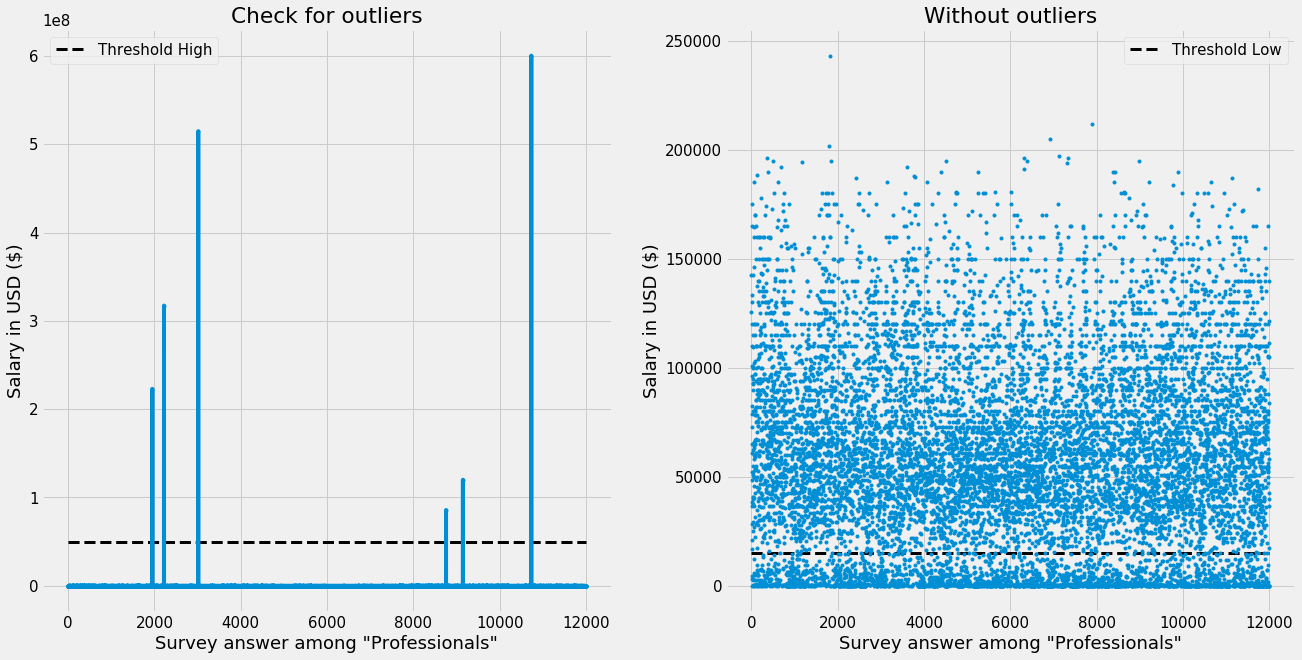

In [12]:
plt.rcParams['figure.figsize']=20, 10

# these 2 thresholds have established after visual inspection of the salary responses
thr_high = 0.5e8
thr_low = 15000

plt.subplot(1,2,1)
df_pro['SalaryConv_USD'].plot(style='.-', title='Check for outliers', label='')
plt.hlines(y = thr_high, xmin=0, xmax=len(df_pro), ls='dashed', lw=3,label='Threshold High')
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Professionals"')
plt.legend()


plt.subplot(1,2,2)
df_pro.query(f'SalaryConv_USD < {thr_high}')['SalaryConv_USD'].plot(style='.', title='Without outliers', label='')
plt.hlines(y = thr_low, xmin=0, xmax=len(df_pro), ls='dashed', lw=3, label='Threshold Low')
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Professionals"')
plt.legend()


> After converting the salaries to USD and filtering out the few outliers over 500,000 USD, there is still a very high representation of low level salaries that are skewing the data towards 0.  It is difficult to know if these low salaries reflect a reality or are the results of errors. We decided to remove the respondents with USD Salary < 15,000 USD for that reason.

In [13]:
df_filtered = df_pro.query(f'(SalaryConv_USD < {thr_high}) & (SalaryConv_USD > {thr_low})').reset_index(drop=True)

__4. Distribution of salary over all "Professionals"__

Text(70000.0, 542.45, 'Median salary $65000.00')

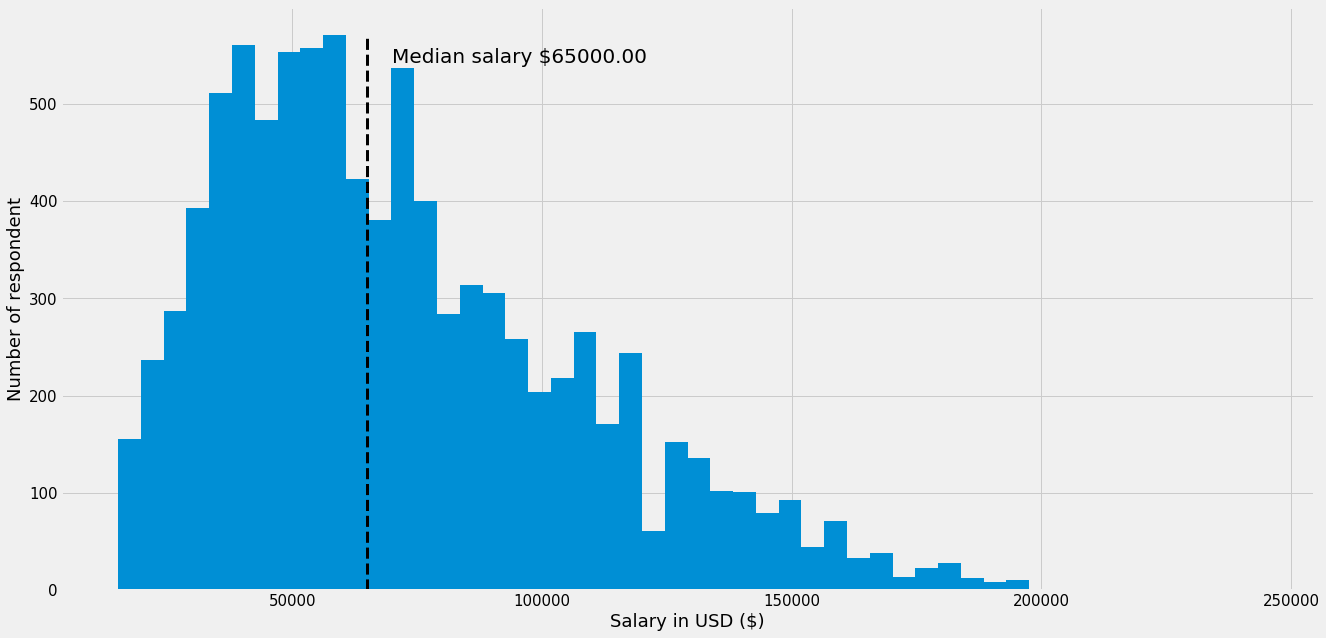

In [14]:
sal_median = df_filtered['SalaryConv_USD'].median()
topLim = pd.cut(df_filtered['SalaryConv_USD'],50).value_counts().max()

plt.hist(df_filtered['SalaryConv_USD'], bins=50)
plt.xlabel('Salary in USD ($)')
plt.ylabel('Number of respondent')
plt.vlines(x = sal_median, ymin=0, ymax=topLim, linestyles='--', lw=3)
plt.text(sal_median+5000, topLim-topLim*0.05, f'Median salary ${sal_median:.2f}',fontsize=20)


> This sub-sample ```df_filtered``` being the largest reliable sample, it will be used for the salary prediction model
- [Predict model of Salary in USD with linear model](#model)

___
### Who are the Recent-Hires?
We will restrict our analysis to new hires to have a better understanding of good advices for breaking into the field.

In [15]:
txt = df_sch.query('Column == "LastNewJob"')['Question'].tolist()[0]
md(f'__The Question read as:__<br/> _{txt}_')

__The Question read as:__<br/> _When was the last time that you took a job with a new employer?_

Text(0.5, 1.0, 'Percentage of Professionals by time in new job')

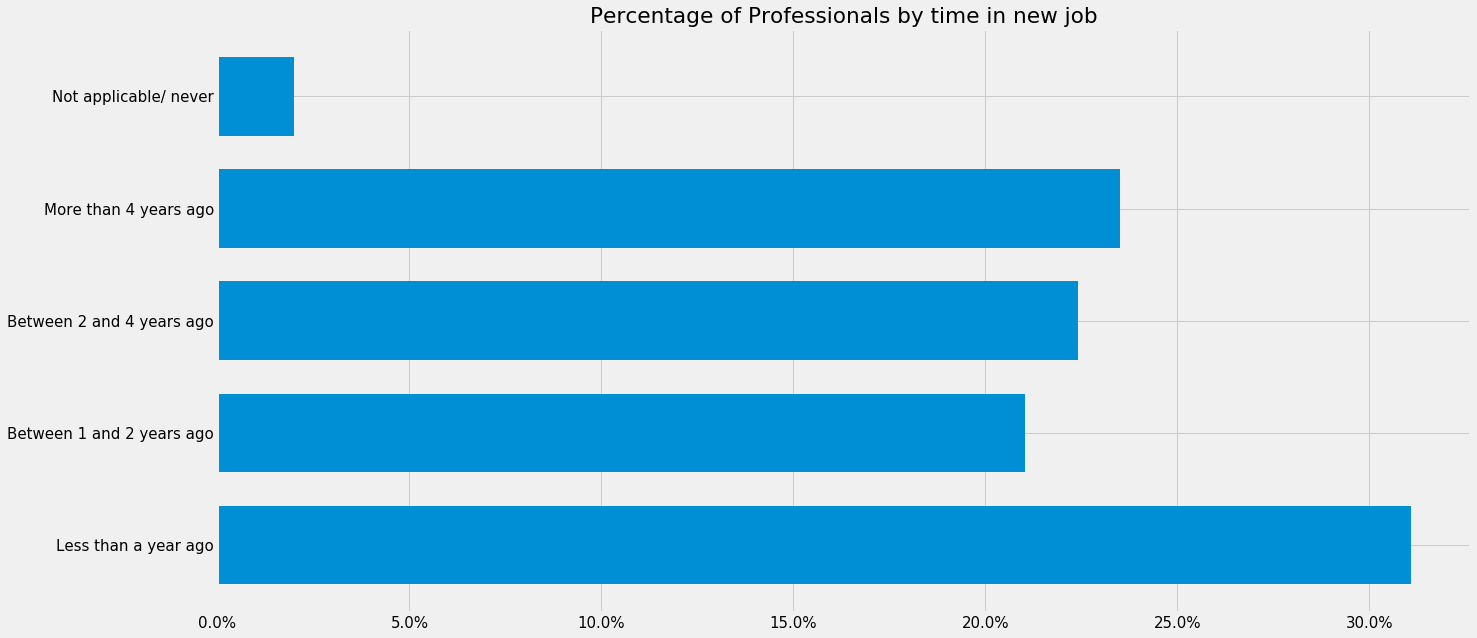

In [16]:
# percentage of responsdent by time in new job
per_nhires = df_filtered['LastNewJob'].value_counts(normalize=True).reindex(index = 
                                                                      [
                                                                          'Less than a year ago',
                                                                          'Between 1 and 2 years ago',
                                                                          'Between 2 and 4 years ago',
                                                                          'More than 4 years ago',
                                                                          'Not applicable/ never'
                                                                      ]
                                                                     )

ax_nhires = per_nhires.plot(kind='barh', width=0.7)
ax_nhires.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('Percentage of Professionals by time in new job')

> Recent-Hires are defined has professional respondents that have been hired in a new job less than 4 years prior to the survey.

In [17]:
df_nhires = df_filtered.query('LastNewJob in ["Less than a year ago","Between 1 and 2 years ago","Between 2 and 4 years ago"]')
# df_nhires = df_pro.query('LastNewJob in ["Less than a year ago","Between 1 and 2 years ago"]')

> This sub-sample ```df_nhires``` will be used for all questions related to _Recent-hires_
- [Recommendations from Recent-hires](#Recommendations-from-"Recent-hires")
- [How did the Recent-hires break into the field?](#How-did-the-Recent-hires-break-into-the-field?)
- [Sucess for Recent-hires by Training](#Sucess-for-Recent-hires-by-Training-(Job-Satifaction-&-Salary))

---
### Who are the Data Scientists?

> We are using the ```getChoices()``` function to extract all unique possible choices in ```'DeveloperType'``` -> we will obtain all observations where each unique choices were found


In [18]:
# who is a data scientist?
dict_devTypes = getChoices(df_nhires['DeveloperType'])
list(dict_devTypes.keys())

['Other',
 'Embedded applications/devices developer',
 'Web developer',
 'Mobile developer',
 'Graphics programming',
 'Desktop applications developer',
 'DevOps specialist',
 'Developer with a statistics or mathematics background',
 'Systems administrator',
 'Quality assurance engineer',
 'Data scientist',
 'Graphic designer',
 'Database administrator',
 'Machine learning specialist']

> We decided to define data scientist as "Data Scientist" and "Machine learning specialist"

In [19]:
# finding the indices of these unique respondent
idx_dataSci = list(set(dict_devTypes['Data scientist']+dict_devTypes['Machine learning specialist']))

# recent-hires data scientist
df_dataSci = df_nhires.reindex(idx_dataSci)

md(
    f'We identified only __{len(df_dataSci)}__ recent-hires data scientists'
)


We identified only __435__ recent-hires data scientists

> This sub-sample ```df_dataSci``` will be used for all questions related to _data scientists_
- [Formal education and Training for Data Scientists](#Formal-education-and-Training-for-Data-Scientists)

---
### Extracting categorical variables and create dummy variables for linear model

We are extracting all categorical variables to split and encode them into the appropriate unique response. This will enable the use of such categorical variables into or linear estimator (see [prediction model](#Predict-model-of-Salary-in-USD-with-linear-model)).

Missing values are replaced by 0, which will equate to no response over the set of unique choices.

In [20]:
cat_df = df_filtered.select_dtypes(include='object')
columns = cat_df.columns.tolist()

In [21]:
X_cat = pd.DataFrame()
for col in columns:
    X_cat = pd.concat([X_cat, createDummyVar(df_filtered[col])], axis=1)


In [22]:
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9329 entries, 0 to 9328
Columns: 1066 entries, Professional.Professional developer to InterestedAnswers.Strongly disagree
dtypes: int64(1066)
memory usage: 75.9 MB


> By using the customized ```getChoices()``` function we limited the number of dummy variables to 1066 using only the unique choices for each survey questions (instead of 11938 as presented in example)

---
### Cleaning numerical variables about Satisfaction
(see [prediction model](#Predict-model-of-Salary-in-USD-with-linear-model))

In [23]:
# extract numerical variables and explore their content
num_df = df_filtered.select_dtypes(exclude='object')
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9329 entries, 0 to 9328
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Respondent                 9329 non-null   int64  
 1   CareerSatisfaction         9304 non-null   float64
 2   JobSatisfaction            9296 non-null   float64
 3   HoursPerWeek               3925 non-null   float64
 4   StackOverflowSatisfaction  8813 non-null   float64
 5   Salary                     9329 non-null   float64
 6   ExpectedSalary             0 non-null      float64
 7   SalaryConv_USD             9329 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 583.2 KB


In [24]:
nan_hours = num_df['HoursPerWeek'].isna().sum()/len(num_df)
md(f'> We decided to remove "HoursPerWeek" from the numerical variable since __{nan_hours:.2%}__ of the data were missing')

> We decided to remove "HoursPerWeek" from the numerical variable since __57.93%__ of the data were missing

In [25]:
#clean "numerical" variables: impute missing data with median values
col_sat = ['CareerSatisfaction', 'JobSatisfaction', 'StackOverflowSatisfaction']
df_sat = num_df[col_sat].apply(lambda col:col.fillna(col.median()), axis=0)

> All numerical variables used in the model represent Satisfaction scores that are Ordinal by definition (integer values that represent a ranking system and not a continous scale). The median is therefore more representative of the data and this why we chose this imputation method.

---
---
## __Section 4. Data analysis & Modeling__


---
<a id='recommendation'></a>
### Recommendations from "Recent-hires"

In [26]:
txt = df_sch.query('Column == "CousinEducation"')['Question'].values[0].replace('\n', '<br/>')
md(f'__The Question read as:__<br/> _{txt}_')

__The Question read as:__<br/> _Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?<br/>Let's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?<br/>Let's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Alice?_

In [27]:
dictEducAdv = getChoices(df_nhires['CousinEducation'])
# count values for each category of 'CousinEducation' 
AdvCount = {k: len(v) for k, v in dictEducAdv.items()}
AdvCount

{'Get a job as a QA tester': 385,
 'Take online courses': 1631,
 'Participate in online coding competitions': 314,
 'Buy books and work through the exercises': 1249,
 'Contribute to open source': 905,
 'Conferences/meet-ups': 703,
 'Return to college': 593,
 "Master's degree": 280,
 'Other': 292,
 'Part-time/evening courses': 765,
 'Bootcamp': 636,
 'Participate in hackathons': 327,
 'None of these': 40}

Text(0.5, 1.0, 'What would you most strongly recommend to your cousin?')

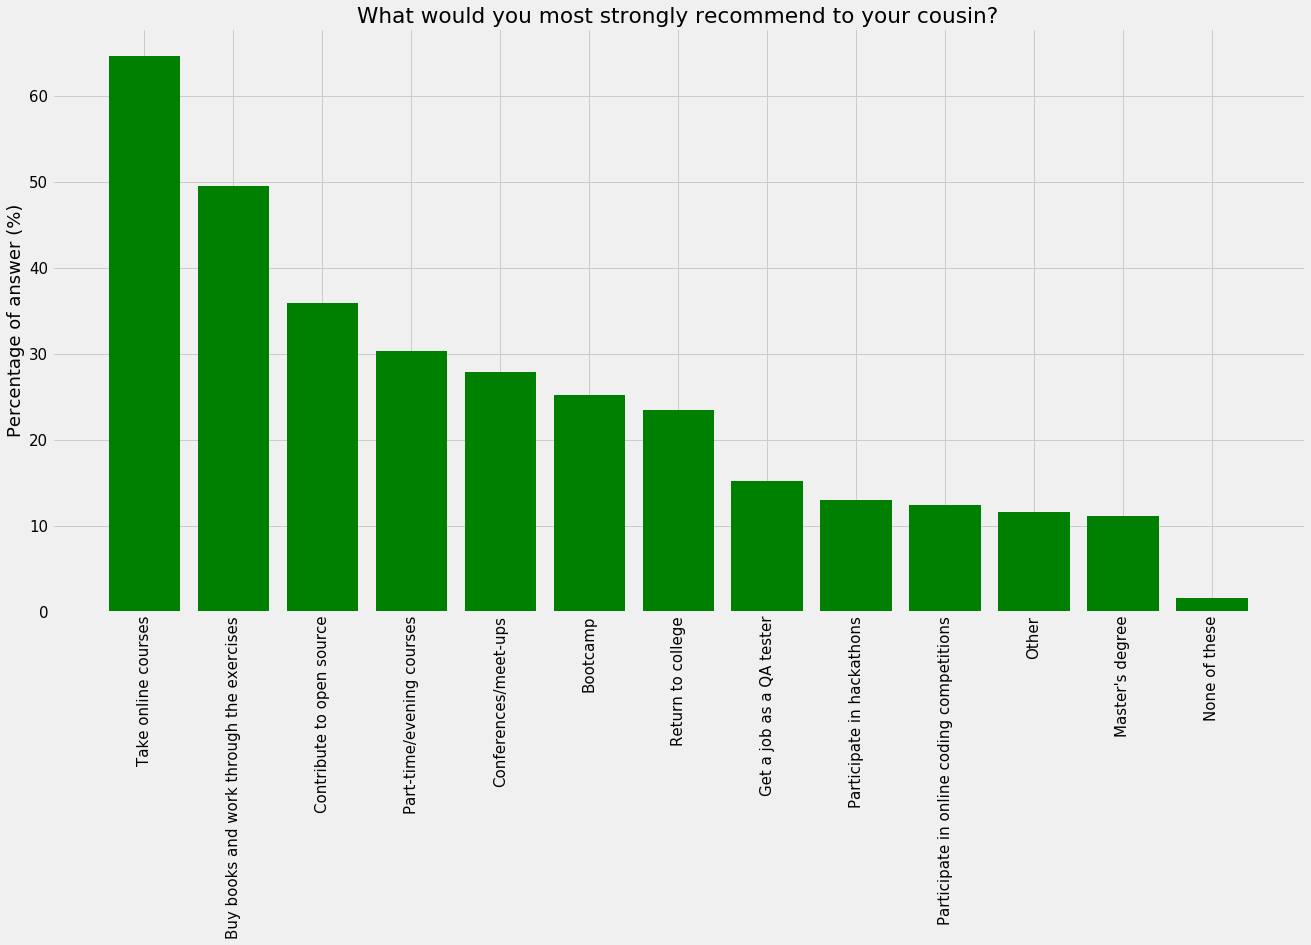

In [28]:
# first we reorder answers by count
mask = ~df_nhires['CousinEducation'].isna()
total_respondent = mask.sum()

AdvCount = dict(sorted(AdvCount.items(), key=lambda x: x[1], reverse=True)) ## reorder dictionnary
perc_Adv = np.array(list(AdvCount.values()))/total_respondent # compute percentage over respondent that answer this question

plt.bar(list(AdvCount.keys()), perc_Adv*100, color='g')
plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)
plt.title('What would you most strongly recommend to your cousin?')

In [29]:
pos_str = ['1st', '2nd', '3rd']
txt = ''
for pos in range(len(pos_str)):
    txt += (f'The {pos_str[pos]} most given advice is to _"{list(AdvCount.keys())[pos]}"_ with __{perc_Adv[pos]:.2%}__ of the votes.<br/>')

md(txt)

The 1st most given advice is to _"Take online courses"_ with __64.59%__ of the votes.<br/>The 2nd most given advice is to _"Buy books and work through the exercises"_ with __49.47%__ of the votes.<br/>The 3rd most given advice is to _"Contribute to open source"_ with __35.84%__ of the votes.<br/>

> About 65% of the Recent-hires advice to Take online classes to switch career to a software developer

---
<a id='education'></a>
### How did the Recent-hires break into the field?
We will explore their formal education and their training to investigate how they did get their new job.

In [30]:
txt1 = df_sch.query('Column == "FormalEducation"')['Question'].values[0]
txt2 = df_sch.query('Column == "EducationTypes"')['Question'].values[0]
md(
    f'We will focus first on __Formal Education__: <br/> _{txt1}_<br/>'
    +f'Then, we will look at __Education types__: <br/> _{txt2}_'
)


We will focus first on __Formal Education__: <br/> _Which of the following best describes the highest level of formal education that you've completed?_<br/>Then, we will look at __Education types__: <br/> _Outside of your formal schooling and education, which of the following have you done?_

In [31]:
dictEducType = getChoices(df_nhires['EducationTypes'])

# count values for each category of 'Training' 
EdTypeCount = {k: len(v) for k, v in dictEducType.items()}

# first we reorder answers by count
EdTypeCount = dict(sorted(EdTypeCount.items(), key=lambda x: x[1], reverse=True)) ## reorder dictionnary
perc_EdType = np.array(list(EdTypeCount.values()))/len(df_nhires) # compute percentage over all participants

# count values for each category of 'Formal Education' 
FormalEdu = df_nhires['FormalEducation'].value_counts(normalize=True)

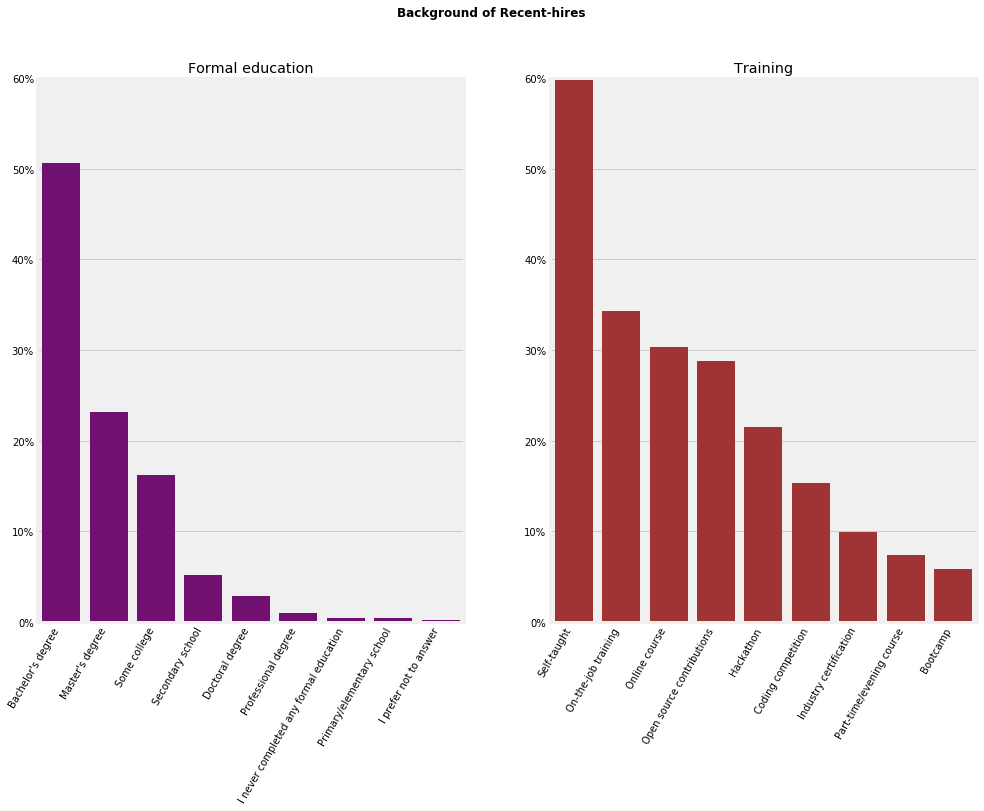

In [149]:
plt.rcParams['figure.figsize']= 15,10
xlabel = FormalEdu.index.tolist()
xlabel[2] = 'Some college'

plt.subplot(1,2,1)
plt.suptitle("Background of Recent-hires", weight=900)
b1 = sns.barplot(
    x = xlabel,
    y = FormalEdu.values*100,
    color='purple'
)
plt.xticks(rotation=60, ha='right')
# plt.ylabel('Percentage of answer (%)')
plt.title("Formal education")
plt.ylim(top=60)
b1.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.subplot(1,2,2)
b2 = sns.barplot(list(EdTypeCount.keys()), perc_EdType*100, color='firebrick')
# plt.ylabel('Percentage of answer')
plt.xticks(rotation=60, ha='right')
plt.title("Training")
plt.ylim(top=60)
b2.yaxis.set_major_formatter(mtick.PercentFormatter())

In [33]:
txt1 = f'The overwelming majority of recent-hires arrived in the field with a {FormalEdu.index[0]}'
val1 = f'{FormalEdu[0]:.2%}'

txt2 = f" and prefer the 'Self-taught' method ({perc_EdType[0]:.2%}). Online course represents ({perc_EdType[2]:.2%}) of informal training responses"

md(
    '>'+txt1+' ('+val1+'), '+txt2
)

>The overwelming majority of recent-hires arrived in the field with a Bachelor's degree (50.67%),  and prefer the 'Self-taught' method (62.38%). Online course represents (30.33%) of informal training responses

---
<a class=anchor id='success'></a>  
### Sucess for Recent-hires by Training (Job Satifaction & Salary)


__1. Job Satisfaction__

,Training,Median,Mean
2,Coding competition,7.0,6.945479
3,Online course,7.0,7.002688
8,Industry certification,7.0,7.022587
0,Self-taught,8.0,7.122796
1,Part-time/evening course,8.0,7.152355
7,On-the-job training,8.0,7.230404
5,Hackathon,8.0,7.278517
6,Open source contributions,8.0,7.288352
4,Bootcamp,8.0,7.370629


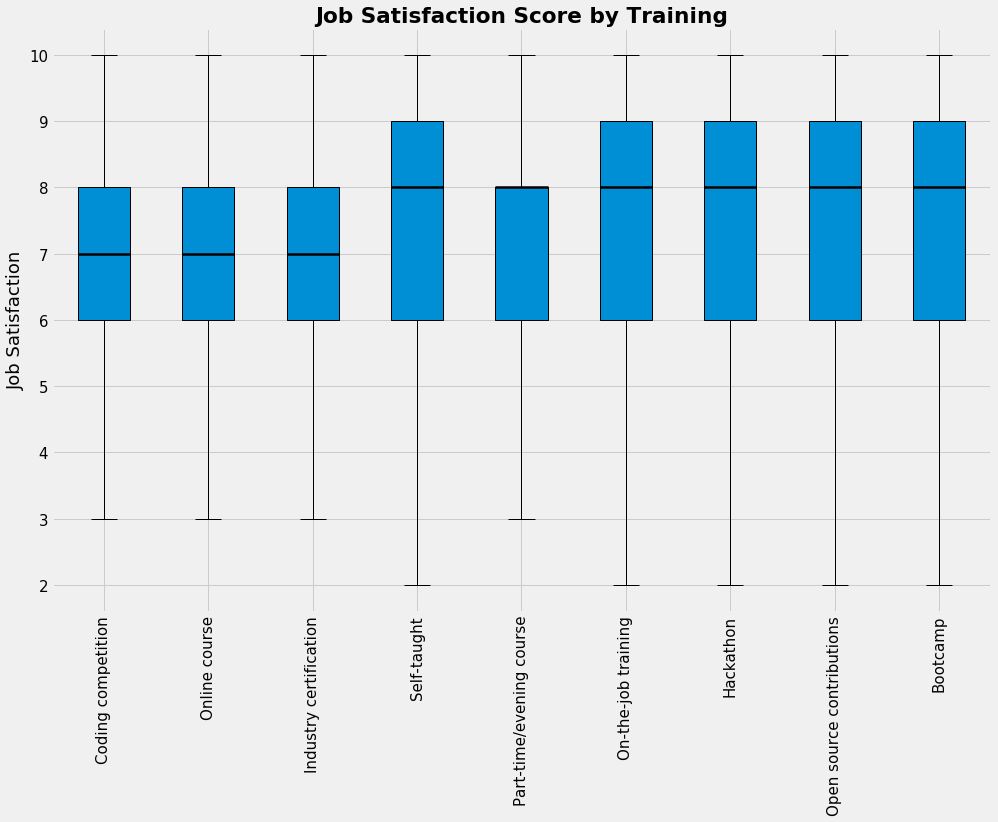

In [34]:
Job_sat = []
jobsat_2_plot = []

for adv, idx in dictEducType.items():
    n_data = df_nhires.reindex(idx)['JobSatisfaction']
    
    jobsat_2_plot.append(n_data.dropna())
    
    Job_sat.append(
        {
            'Training': adv,
            'Median': n_data.median(),
            'Mean':  n_data.mean()
        }
    )


JobSat = pd.DataFrame(Job_sat).sort_values(by=['Median', 'Mean'])
my_order = JobSat.index.tolist() # find order the list of list of salary by Median
jobsat_2_plot = [jobsat_2_plot[x] for x in my_order] # reorganize data_2_plot for boxplot

fig = plt.figure()
ax = fig.add_subplot(111)
medianprops = dict(linewidth=2.5, color='black')
bp = plt.boxplot(jobsat_2_plot, patch_artist=True, medianprops=medianprops, showfliers=False)
ax.set_xticklabels(JobSat['Training'],rotation=90)
plt.ylabel('Job Satisfaction')
plt.title('Job Satisfaction Score by Training', weight='bold')

JobSat


> The satisfaction score are fairly high and similar between the recent-hires training.  
The boxplots above show __no differences__ in job satisfaction based on the respondent training.

__2. Salary__

,Advice,Median,Mean,Std
3,Online course,62753.689265,70531.926326,35893.622610
0,Self-taught,63169.560400,71896.056213,36620.341860
7,On-the-job training,65053.476306,73017.380157,35932.937105
1,Part-time/evening course,65711.493316,72855.999868,37532.521786
4,Bootcamp,65891.373728,73904.568539,35747.626416
2,Coding competition,66745.161290,74985.267644,36555.362450
6,Open source contributions,70192.903226,78294.797920,38798.199904
8,Industry certification,72812.903226,77417.626181,38040.073064
5,Hackathon,72812.903226,79166.250952,38360.076939


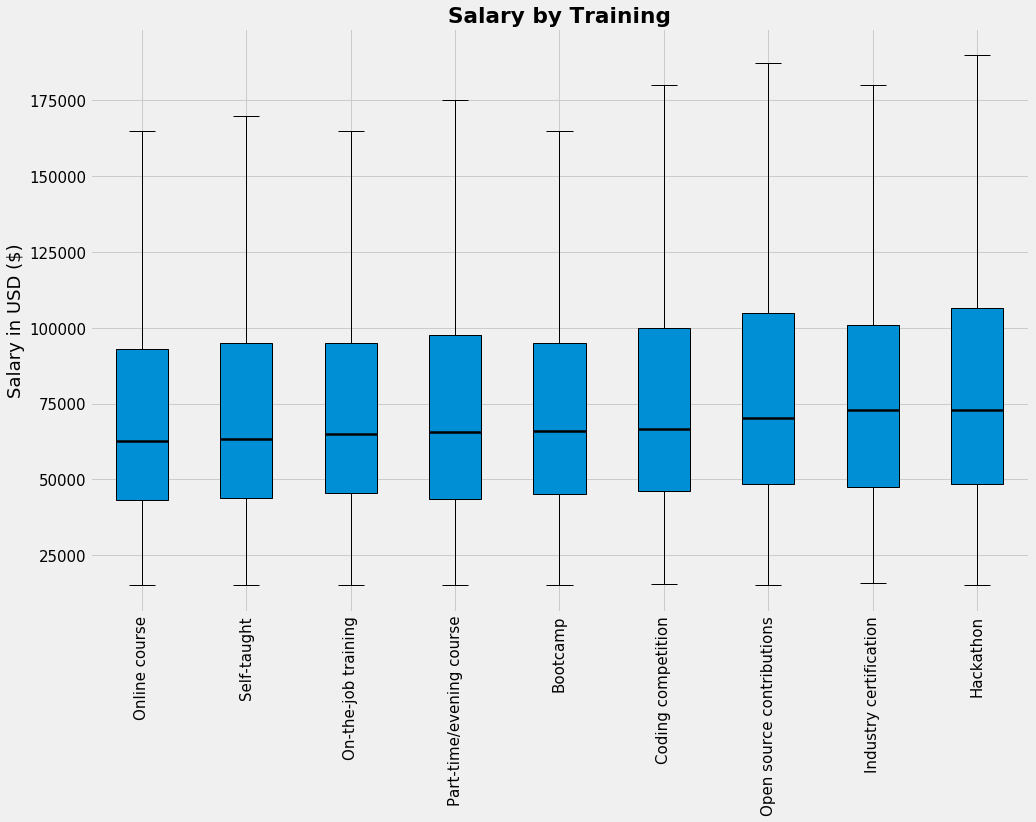

In [35]:
Sal_per_Adv = []
sal_2_plot = []

for adv, idx in dictEducType.items():
    sal = df_filtered.reindex(idx)['SalaryConv_USD']
    
    sal_2_plot.append(sal.dropna())
    
    Sal_per_Adv.append(
        {
            'Advice': adv,
            'Median': sal.median(),
            'Mean':  sal.mean(),
            'Std': sal.std()
        }
    )
    
Sal_per_Adv = pd.DataFrame(Sal_per_Adv).sort_values(['Median','Mean'])
my_order = Sal_per_Adv.index.tolist() # find order the list of list of salary by Median
sal_2_plot = [sal_2_plot[x] for x in my_order] # reorganize data_2_plot for boxplot

fig = plt.figure()
ax = fig.add_subplot(111)
medianprops = dict(linewidth=2.5, color='black')
bp = plt.boxplot(sal_2_plot, patch_artist=True, medianprops=medianprops, showfliers=False)
ax.set_xticklabels(Sal_per_Adv['Advice'],rotation=90)
plt.ylabel('Salary in USD ($)')
plt.title('Salary by Training', weight='bold')

Sal_per_Adv

> The boxplots above show __no differences__ in salaries based on the respondent training.

---
<a id='datasci'></a>
### Formal education and Training for Data Scientists

In [36]:
dataSciEdu = getChoices(df_dataSci['FormalEducation'])
dataSciEdu_perc = {k: len(v)/len(df_dataSci) for k, v in dataSciEdu.items()}
dataSciEdu_perc = dict(sorted(dataSciEdu_perc.items(), key=lambda x: x[1], reverse=True))

dataSciTra = getChoices(df_dataSci['EducationTypes'])
dataSciTra_perc = {k: len(v)/len(df_dataSci) for k, v in dataSciTra.items()}
dataSciTra_perc = dict(sorted(dataSciTra_perc.items(), key=lambda x: x[1], reverse=True))

(0.0, 70)

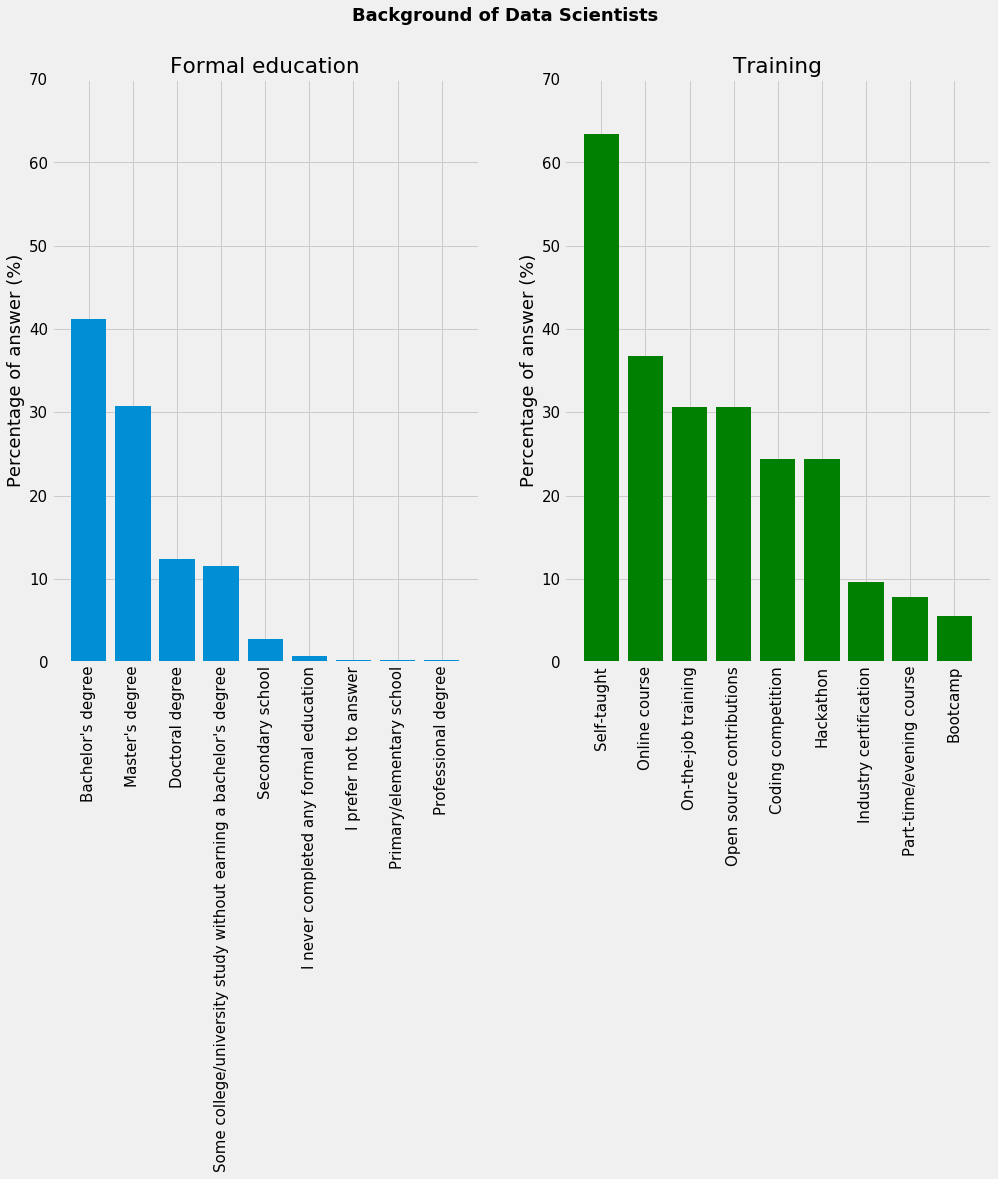

In [37]:
plt.rcParams['figure.figsize']= 15,10

plt.subplot(1,2,1)
plt.suptitle("Background of Data Scientists", weight=900)
plt.bar(
    x=list(dataSciEdu_perc.keys()),
    height = [x*100 for x in list(dataSciEdu_perc.values())]
)
plt.xticks(rotation=90)
plt.ylabel('Percentage of answer (%)')
plt.title("Formal education")
plt.ylim(top=70)

plt.subplot(1,2,2)
plt.bar(
    x=list(dataSciTra_perc.keys()), 
    height= [x*100 for x in list(dataSciTra_perc.values())],
    color='g'
)

plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)
plt.title("Training")
plt.ylim(top=70)

In [38]:
txt1 = list(dataSciEdu_perc.keys())[0]
val1 = dataSciEdu_perc[txt1]
txt2 = list(dataSciTra_perc.keys())[0]
val2 = dataSciTra_perc[txt2]

md(
    f'The highest degree of the majority of recent-hires data scientist is: {txt1} ({val1:.2%})'
    +'<br/>'
    +f'The preferred unformal training of the majority of recent-hires data scientist is: {txt2} ({val2:.2%})'
)

The highest degree of the majority of recent-hires data scientist is: Bachelor's degree (41.15%)<br/>The preferred unformal training of the majority of recent-hires data scientist is: Self-taught (63.45%)

---
### Predict model of Salary in USD with linear model <a class="anchor" id="model"></a>
Taking Salary as measure of sucsess, how well can we predict individual salaries of all professional with this dataset?

Following the guidelines provided on [Scikit Learn tutorial page](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html),  we decided to apply a Linear Support Vector Regression estimator to predict the Salary of Professional respondent.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [40]:
X = pd.concat([df_sat, X_cat], axis=1)
y = df_filtered['SalaryConv_USD']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

# instantiate
# Lin_mod = LinearRegression(normalize=True)
svr_lin = SVR(kernel='linear', C=1000, gamma='auto')

# fit the model / training
# Lin_mod.fit(X_train, y_train)
svr_lin.fit(X_train, y_train)

# predict test data
# y_pred = Lin_mod.predict(X_test)
y_pred = svr_lin.predict(X_test)
y_pred_train = svr_lin.predict(X_train)

# score the model the test
score_test = r2_score(y_test, y_pred)
score_train = r2_score(y_train, y_pred_train)
md(f'The $r^2$ for the test sample is __{score_test:.2%}__<br/> The $r^2$ for the training sample is __{score_train:.2%}__ <br/>')

The $r^2$ for the test sample is __68.43%__<br/> The $r^2$ for the training sample is __74.62%__ <br/>

---
### Model Validation with cross-validation
We are splitting the data in 10-fold to cross validate our model

In [27]:
from sklearn.model_selection import KFold, cross_val_score

In [54]:
svr_lin_k = SVR(kernel='linear', C=1000, gamma='auto')
k_fold = KFold(n_splits=10)

res = cross_val_score(svr_lin,
                X, 
                y, 
                cv=k_fold, 
                scoring='r2', 
                n_jobs=-1)


In [55]:
md(f'Our linear model account for __{res.mean():.2%}__ of the variance of the Salary of the test sample')

Our linear model account for __69.60%__ of the variance of the Salary of the test sample

---
---
## __Section 5. Evaluate the model results__

Since the model is moderately relevant to predict salary we should investigate further what we can learn from the model.

---
### Which features carries the most weight in our linear model?
We are eploring the coedfficient of our SVR linear model to present the top 10 most important features in predicting the Salary of the respondent

In [99]:
SVR_coef = pd.DataFrame()
SVR_coef['Features'] = X.columns
SVR_coef['coef'] = svr_lin.coef_[0]
SVR_coef['abs.coef'] = np.abs(svr_lin.coef_[0])

SVR_coef = SVR_coef.sort_values('abs.coef', ascending=False)
SVR_coef[:20]

,Features,coef,abs.coef
9,Country.United States,37112.486012,37112.486012
529,Currency.Swiss francs,22702.558794,22702.558794
29,Country.Switzerland,20702.558794,20702.558794
223,YearsCodedJob.Less than a year,-17151.469870,17151.469870
42,Country.Ireland,16447.017721,16447.017721
13,Country.Germany,16145.129203,16145.129203
537,Overpaid.Greatly underpaid,-14067.813738,14067.813738
209,YearsCodedJob.1 to 2 years,-13175.926885,13175.926885
22,Country.Ukraine,-12287.188530,12287.188530
205,YearsCodedJob.20 or more years,11699.921557,11699.921557


> Besides differences in the preparation of the data and the choice of model in this analysis compared to the exrecise presented in the Udacity DataScience Nanodegree, the country of residence and the experince as a coder keep being the most relevant factor determining the salary of the respondent.

---
### Looking closer at 'Country' and 'YearsCodedJob'

Text(0.5, 0, 'Salary in USD')

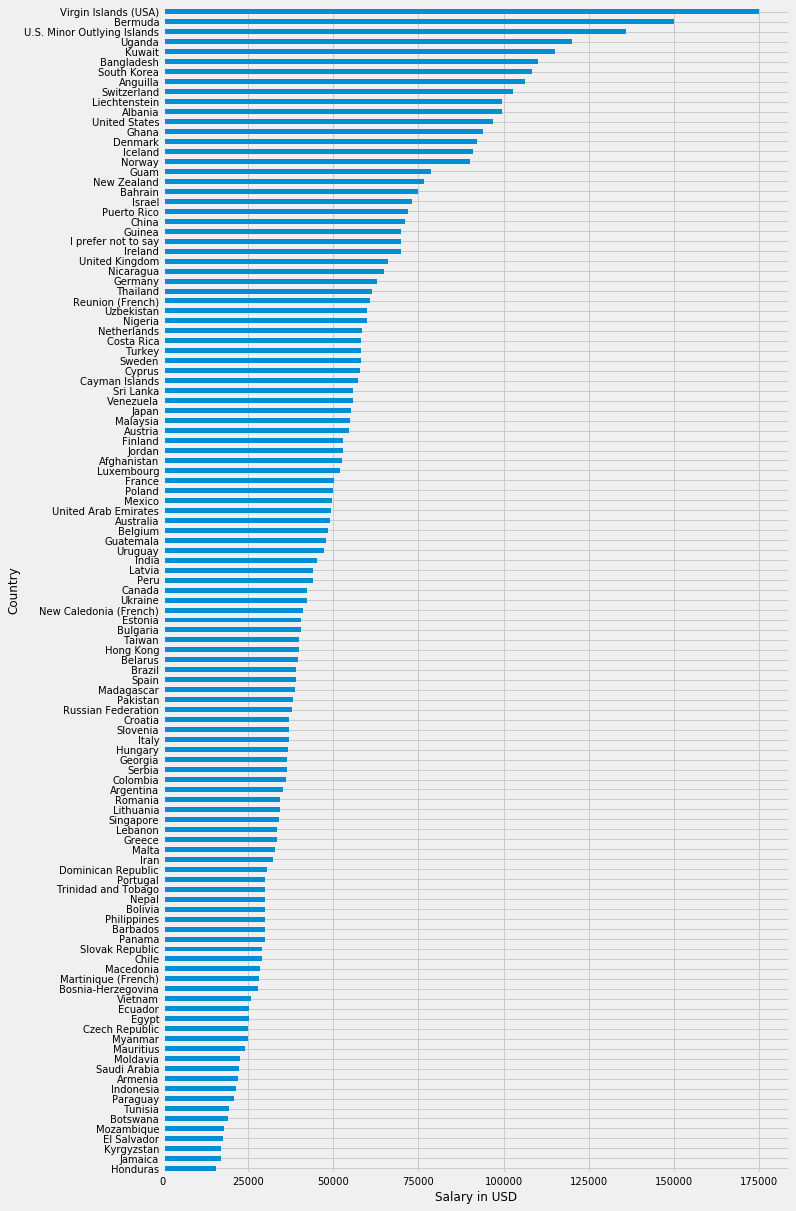

In [30]:
plt.rcParams['figure.figsize']=10,20
plt.rcParams['font.size']=10
df_filtered.groupby(['Country'])['SalaryConv_USD'].mean().sort_values().plot(kind='barh')
plt.xlabel('Salary in USD')

In [43]:
# reorganize YearsCodedJob chronologically
list_years = df_filtered['YearsCodedJob'].value_counts().index.tolist()
list_years.sort(key = lambda x: int(x.split(' ')[0]) if not x.startswith('L') else 0)

Text(0, 0.5, 'Salary in USD')

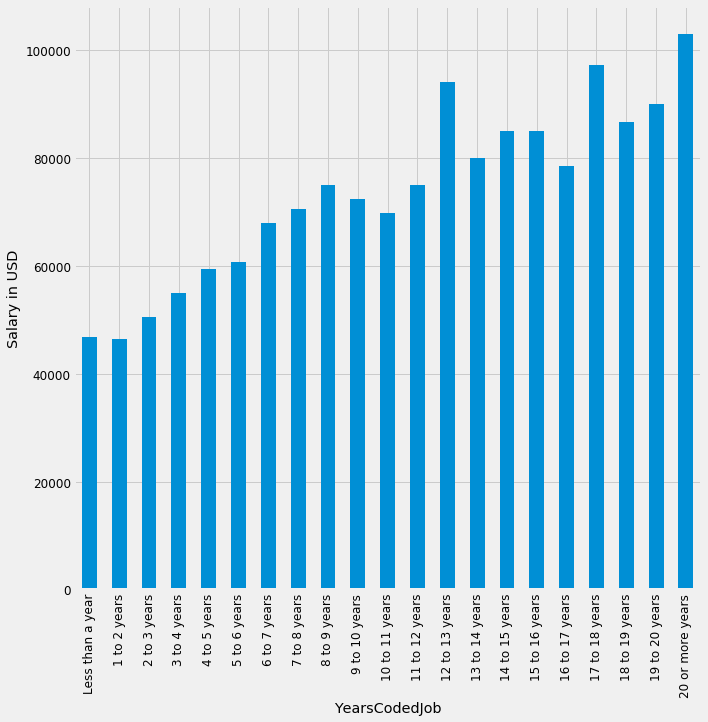

In [32]:
# plot median salary per years of experience
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=12
df_filtered.groupby(['YearsCodedJob'])['SalaryConv_USD'].median().reindex(list_years).plot(kind='bar')
plt.ylabel('Salary in USD')

In [50]:
df_filtered['YearsCodedJob'] = df_filtered['YearsCodedJob'].\
                astype('category').\
                cat.\
                reorder_categories(list_years, ordered=True)

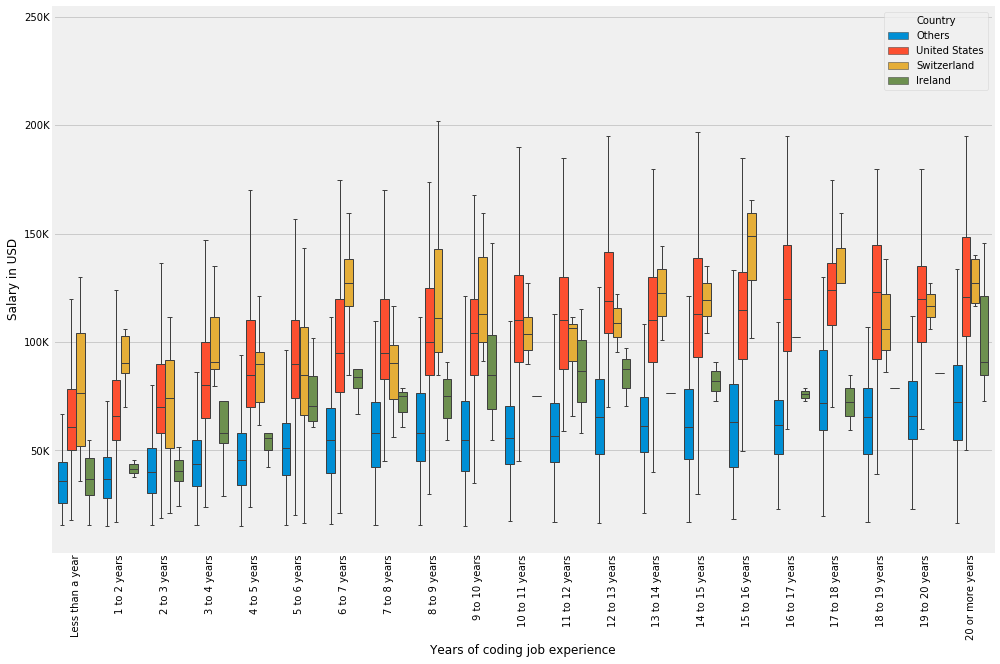

In [150]:
# extract first 3 countries contributing the most to the model
list_hue = [x.split('.')[1] for x in SVR_coef['Features'][:10] if x.startswith('Country')]
list_hue = list_hue[:3]

# create a new tag name for countries other than main contributors
df_filtered['Country Model']=[x if x in list_hue else 'Others' for x in df_filtered['Country']]

# graphical representation
f=plt.figure()
ax = sns.boxplot(
    data=df_filtered, 
    x='YearsCodedJob',
    y='SalaryConv_USD',
    order=list_years,
    hue='Country Model',
    dodge=True,
    linewidth=1,
    saturation=1,
    fliersize=0
)

ax.set_xticklabels(ax.get_xticklabels(),fontdict={'rotation':90, 'fontsize':10})
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'fontsize':10})
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p: '{:}K'.format(int(x/1000))))
plt.xlabel('Years of coding job experience')
plt.ylabel('Salary in USD')
ax.legend(title='Country')


---
## __Section 6. Deployment__
not applicable in this example